# Define paths

In [1]:
from pathlib import Path

project_folder = str(Path(Path.cwd()).parents[1])

plots_folder = project_folder + "/TeX/figs/"

# Import solar model

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

solar_model = pd.read_csv("./Data/bs2005agsopflux.csv", 
                          usecols=[1, 3, *range(6,14)],
                          names = ['radius', 'density_log_10', 'pp fraction', '8B fraction', '13N fraction',
                                   '15O fraction', '17F fraction', '7Be fraction', 'pep fraction',
                                   'hep fraction'],
                          sep=" ", skiprows=27, header=None)

solar_model['density'] = 10**solar_model['density_log_10']
solar_model

,radius,density_log_10,pp fraction,8B fraction,13N fraction,15O fraction,17F fraction,7Be fraction,pep fraction,hep fraction,density
0,0.00041,2.011,3.882000e-07,0.000005,2.829000e-06,0.000004,0.000004,1.910000e-06,6.067000e-07,1.661000e-07,102.565193
1,0.00082,2.011,1.137000e-06,0.000014,8.279000e-06,0.000011,0.000013,5.593000e-06,1.776000e-06,4.865000e-07,102.565193
2,0.00123,2.011,1.886000e-06,0.000023,1.372000e-05,0.000019,0.000021,9.278000e-06,2.948000e-06,8.074000e-07,102.565193
3,0.00164,2.011,2.907000e-06,0.000035,2.113000e-05,0.000029,0.000032,1.430000e-05,4.543000e-06,1.245000e-06,102.565193
4,0.00205,2.011,4.336000e-06,0.000053,3.152000e-05,0.000044,0.000048,2.132000e-05,6.776000e-06,1.857000e-06,102.565193
...,...,...,...,...,...,...,...,...,...,...,...
1214,0.49795,0.071,6.009000e-08,0.000000,2.213000e-15,0.000000,0.000000,1.103000e-16,1.761000e-09,2.902000e-10,1.177606
1215,0.49836,0.069,5.928000e-08,0.000000,2.135000e-15,0.000000,0.000000,1.065000e-16,1.731000e-09,2.843000e-10,1.172195
1216,0.49877,0.067,5.849000e-08,0.000000,2.060000e-15,0.000000,0.000000,1.028000e-16,1.701000e-09,2.785000e-10,1.166810
1217,0.49918,0.065,5.771000e-08,0.000000,1.986000e-15,0.000000,0.000000,9.923000e-17,1.672000e-09,2.728000e-10,1.161449


<AxesSubplot:xlabel='r', ylabel='$n_e(r)$ [mol/cm${}^3$]'>

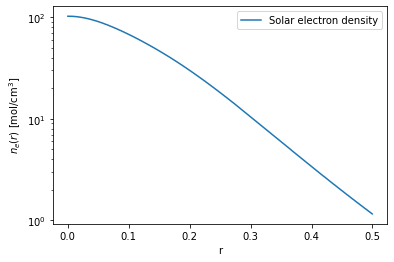

In [3]:
plot = solar_model.plot(x='radius', y='density', logy=True)
plot.set_xlabel("r")
plot.set_ylabel("$n_e(r)$ [mol/cm${}^3$]")
plot.legend(labels=['Solar electron density'])

plt.savefig(plots_folder + "sun_density.pdf")

plot

# Compute solar neutrino survival probability at Sun surface

In [4]:
# Define function for the ratio between matter and vacuum terms in neutrino oscillations
def Vk(Deltam2, E, ne):
    """Vk(Deltam2, E, ne) computes the ratio V/k between the matter and vacuum terms in neutrino oscillations.
    - Deltam2 is the squared mass difference, in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3;
See also Eq.s 4.17, 4.18 in 1802.05781."""
    return (3.868e-7)/(2.533) * (ne / (Deltam2 / E))

In [5]:
from numpy import cos, sin, arcsin, tan, arctan, pi

# Define mixing angles in matter
def th12_M (th12, th13, DeltamSq21, E, ne):
    """th12_M(th12, th13, DeltamSq21, E, ne) computes the mixing angle \theta_{12} in matter.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSq21 is the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3.
See also Eq. 1.22 in FiuzadeBarros:2011qna."""
    return (arctan(tan(2*th12) / (1 - (cos(th13)**2)/(cos(2* th12)) * Vk(DeltamSq21, E, ne))) / 2) % (pi/2)


def th13_M (th13, DeltamSq31, E, ne):
    """th13_M(th13, DeltamSq31, E, ne) computes the mixing angle \theta_{13} in matter.
    - th13 is the vacuum mixing angles \theta_{13} in radians;
    - DeltamSq31 is the vacuum squared mass difference between mass eigenstates 3 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density, in units of mol/cm^3.
See also Eq. 1.22 in FiuzadeBarros:2011qna."""
    return (arcsin(sin(th13) * (1 + Vk(DeltamSq31, E, ne) * cos(th13)**2))) % (pi/2)

In [6]:
# Compute survival probability at Sun surface for fixed energy and electron density
def Pnuenue (th12, th13, DeltamSq21, DeltamSq31, E, ne):
    """Pnuenue(th12, th13, DeltamSq21, DeltamSq31, E, ne) computes the survival probability of an electron neutrino
    neutrino at the Sun surface in the adiabatic approximation, as a function of vacuum oscillation parameters.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSqj1 are the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron matter density at neutrino production point, in units of mol/cm^3.
See also Eq. 6.14 in FiuzadeBarros:2011qna."""
    th12m = th12_M(th12, th13, DeltamSq21, E, ne)
    th13m = th13_M(th13, DeltamSq31, E, ne)
    return cos(th13)**2 * cos(th13m)**2 * (cos(th12)**2 * cos(th12m)**2 + sin(th12)**2 * sin(th12m)**2) + sin(th13)**2 * sin(th13m)**2

<AxesSubplot:xlabel='r', ylabel='Neutrino fraction'>

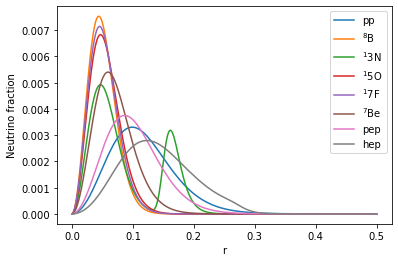

In [205]:
plot = solar_model.plot(x='radius', y=['pp fraction', '8B fraction', '13N fraction',
                                   '15O fraction', '17F fraction', '7Be fraction', 'pep fraction',
                                   'hep fraction'])
plot.set_xlabel('r')
plot.set_ylabel('Neutrino fraction')
plot.legend(labels=['pp', '${}^8$B', '${}^13$N','${}^15$O', '${}^17$F', '${}^7$Be', 'pep', 'hep'])

plt.savefig(plots_folder + "reaction_fraction.pdf")

plot

In [40]:
def Tei (th12, th13, DeltamSq21, DeltamSq31, E, ne):
    """Tei(th12, th13, DeltamSq21, DeltamSq31, E, ne) computes the weights composing an incoherent flux of
    neutrino mass eigenstates, for electron neutrinos produced in matter in the adiabatic approximation:
    - thij are the PMNS mixing angles;
    - DeltamSqj1 are the squared mass differences in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - ne is the electron density at production point, in units of mol/cm^3.
See Eq. (6.11) in FiuzadeBarros:2011qna for its derivation."""
    
    # Compute the mixing angles at neutrino production point
    th13m = th13_M(th13, DeltamSq31, E, ne)
    th12m = th12_M(th12, th13, DeltamSq21, E, ne)
    
    # Compute and return the weights
    c13M = cos(th13m)
    s13M = sin(th13m)
    c12M = cos(th12m)
    s12M = sin(th12m)
    
    return ((c13M * c12M)**2, (c13M * s12M)**2, s13M**2)

    
def solar_flux_mass (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction):
    """solar_flux_mass(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction) computes 
    the weights of mass eigenstates composing the incoherent flux of solar neutrinos in the adiabatic 
    approximation:
    - thij are the PMNS mixing angles;
    - DeltamSqj1 are the squared mass differences in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - radius_samples is a list of solar relative radius values, where density and fraction are sampled;
    - density is the list of electron densities at radii radius_samples, in units of mol/cm^3;
    - fraction is the relative fraction of neutrinos produced in the considered reaction, 
    sampled at radius_samples."""
    
    IntegratedFraction = integrate.trapezoid(y=fraction, x=radius_samples)
    Tei_radius = np.array([Tei(th12, th13, DeltamSq21, DeltamSq31, E, ne_r) for ne_r in density])
    
    [Te1, Te2, Te3] = [
        integrate.trapezoid(y=([Tei_radius[k][i] for k in range(len(Tei_radius))] * fraction), x = radius_samples) / IntegratedFraction 
        for i in range(3)]
    
    return [Te1, Te2, Te3]

In [8]:
from scipy import integrate
import numpy as np

# Compute the survival probability at Sun surface for a given reaction, integrated over the production point
def PnuenueReaction (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction):
    """PnuenueReaction (th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction) computes the
    survival probability at Sun surface for an electron with energy E produced in a specific reaction.
    - th1j are the vacuum mixing angles in radians;
    - DeltamSqj1 are the vacuum squared mass difference between mass eigenstates 2 and 1;
    - E is the neutrino energy, in units of MeV;
    - radius_samples is a list of solar relative radius values where density and fraction are sampled;
    - density is the list of electron densities at radii radius_samples, in units of mol/cm^3;
    - fraction is the relative fraction of neutrinos produced in the considered reaction, 
    sampled at radius_samples."""
    
    IntegratedFraction = integrate.trapezoid(y=fraction, x=radius_samples)
    PnuenueRadius = np.array([Pnuenue(th12, th13, DeltamSq21, DeltamSq31, E, ne_r) for ne_r in density])
    
    return integrate.trapezoid(y=(PnuenueRadius * fraction), x = radius_samples) / IntegratedFraction

In [9]:
from math import sqrt

th12 = arctan(sqrt(0.469))
th13 = arcsin(sqrt(0.01))
DeltamSq21 = 7.9e-5
DeltamSq31 = 2.46e-3
E = 10
ne = 100
radius_samples = solar_model.radius
density = solar_model.density
fraction = solar_model['8B fraction']

xrange = np.arange(1,20,0.1)
ProbB8 = [PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, solar_model['8B fraction']) for E in xrange]
Probhep = [PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, solar_model['hep fraction']) for E in xrange]

In [10]:
SNO_B8 = pd.read_csv("./Data/B8.csv", names=['energy', 'Pnuenue'])
SNO_hep = pd.read_csv("./Data/hep.csv", names=['energy', 'Pnuenue'])

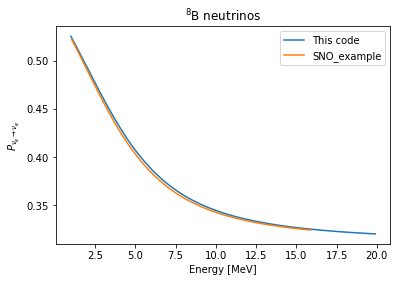

In [11]:
plt.plot(xrange, ProbB8, label="This code")
plt.plot(SNO_B8.energy, SNO_B8.Pnuenue, label='SNO_example')
plt.title("${}^8$B neutrinos")
plt.xlabel('Energy [MeV]')
plt.ylabel(r"$P_{\nu_e \rightarrow \nu_e}$")
plt.legend()
plt.savefig(plots_folder + "8B_SNO_cmparison.pdf")

plt.show()

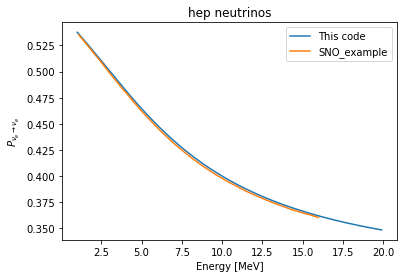

In [12]:
plt.plot(xrange, Probhep, label="This code")
plt.plot(SNO_hep.energy, SNO_hep.Pnuenue, label='SNO_example')
plt.title("hep neutrinos")
plt.xlabel('Energy [MeV]')
plt.ylabel(r"$P_{\nu_e \rightarrow \nu_e}$")
plt.legend()
plt.savefig(plots_folder + "hep_SNO_comparison.pdf")

plt.show()

# Earth regeneration

### It is not necessary to define a new function for undergroud detector:
- for $0 \leq \eta \leq \pi/2$: use total path for first half of propagation, then stop at $r_{det} = 1 - h$ for second half;
- for $\pi/2 \leq \eta \leq \pi$: just use downstream path (with constant density? The density variation is at most $10^{-4}$ for SNO)

In [13]:
import numpy as np
from math import sin, cos, sqrt

def EarthDensity (x = 0, eta = 0, parameters = False): 
    """EarthDensity(x, eta, integrated) computes:
    - if parameters == False: the value of Earth electron density in units of mol/cm^3 for trajectory coordinate 
    x and nadir angle eta;
    - if parameters == True: a list of lists, where each element [[a, b, c], x_i] refers to a Earth shell 
    (from inner to outer layers) having density profile n_e(x) = a + b x^2 + c x^4, with shell external boundary 
    at x == x_i.
See hep-ph/9702343 for the definition of trajectory coordinate and Earth density parametrisation."""
    
    # The density profile is symmetric with respect to x=0 
    x = np.abs(x)
    
    # If x > cos(eta) the trajectory coordinate is beyond Earth surface, thus density is zero.
    if ((~parameters) & (x > cos(eta))):
        return 0
    else:
        # Define the Earth density parametrisation, in units of mol/cm^3, following hep-ph/9702343
        alpha = np.array([6.099, 5.803, 3.156, -5.376, 11.540])
        beta = np.array([-4.119, -3.653, -1.459, 19.210, -20.280])
        gamma = np.array([0, -1.086, 0.280, -12.520, 10.410])

        rj = np.array([0.192, 0.546, 0.895, 0.937, 1])

        # Select the index "idx_shells" in rj such that for i >= idx_shells => rj[i] > sin(eta)
        # The shells having rj[i] > sin(eta) are the ones crossed by a path with nadir angle = eta
        idx_shells = np.searchsorted(rj, sin(eta))
        
        # Keep only the parameters for the shells crossed by the path with nadir angle eta
        alpha_prime = alpha[idx_shells::] + beta[idx_shells::] * sin(eta)**2 + gamma[idx_shells::] * sin(eta)**4
        beta_prime = beta[idx_shells::] + 2 * gamma[idx_shells::] * sin(eta)**2
        gamma_prime = gamma[idx_shells::]

        # Compute the value of the trajectory coordinates xj at each shell crossing
        xj = np.sqrt( (rj[idx_shells::])**2 - sin(eta)**2 )

        # The index "idx" determines within which shell xj[idx] the point x is
        idx = np.searchsorted(xj, x)
        
        # If parameters == true, the function returns the values of the density parameters for the shells 
        # crossed by the path with nadir angle = eta
        if parameters:
            return [ [ [alpha_prime[i], beta_prime[i], gamma_prime[i]], xj[i] ] for i in range(len(alpha_prime))]
       
        # If parameters == False, return the value of electron density at trajectory point x for nadir angle = eta
        else:
            return alpha_prime[idx] + beta_prime[idx] * x**2 + gamma_prime[idx] * x**4

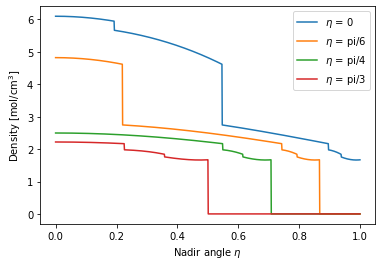

In [14]:
import matplotlib.pyplot as plt
from math import pi

x = np.arange(0,1,0.001)
eta = [0, pi/6, pi/4, pi/3]
labels = ["0", "pi/6", "pi/4", "pi/3"]

density = [ [EarthDensity(r, n) for r in x] for n in eta]

plt.xlabel("Nadir angle $\eta$")
plt.ylabel("Density [mol/cm${}^3$]")
for i in range(len(density)):
    plt.plot(x,density[i], label = "$\eta$ = %s" %labels[i])
plt.legend()
plt.savefig(plots_folder + "earth_density.pdf")
    
plt.show()

The density can be approximated as constant for downstream paths

In [15]:
h = 2 / 6.371e3

(EarthDensity(1) - EarthDensity(1-h))/(EarthDensity(1) + EarthDensity(1-h))

0.00010027377254072573

# Compute Earth matter regeneration

In [16]:
import numpy as np
from math import cos, sin, atan
from cmath import exp
from cmath import sqrt as csqrt

In [17]:
# Earth radius R_E: since we integrate over the dimensionless parameter r = R/R_E, the Hamiltonian must be
# multiplied by R_E
R_E = 6.371e6 # meters

# Matter potential
def MatterPotential (n):
    """MatterPotential(n) computes the matter potential due to an electron density n, expressed in mol/cm^3
See Eq. 4.17 in 1802.05781."""
    # n in mol / cm^3
    return R_E * 3.868e-7 * n

# Kinetic potential
def k(mSq, E):
    """k(mSq, E) computes the kinetic potential for an ultrarelativistic neutrino:
    - mSq is the squared mass (or mass difference) in units of eV^2;
    - E is the neutrino energy in MeV.
See Eq. 4.18 in 1802.05781."""
    # mSq in eV^2, E in MeV
    return R_E * 2.533 * mSq / E

In [18]:
# Computes coefficients of the characteristic equation for the matrix T = H - Tr(H)/3, cf. hep-ph/9910546 
def c0 (m1Sq, m2Sq, m3Sq, th12, th13, E, n):
    """c0(m1Sq, m2Sq, m3Sq, E, n) computes the coefficient c_0 defined in hep-ph/9910546, for the specific case
    in which the mixing matrix is the reduced one U = R_{13} R_{12}:
    - miSq are the squared masses (or mass differences) in units of eV**2;
    - thij are the PMNS mixing angles;
    - E is the neutrino energy, in units of MeV;
    - n is the electron matted density, in units of mol/cm**3.
See hep-ph/9910546 for the full context of the definition."""
    [k1, k2, k3] = k(np.array([m1Sq, m2Sq, m3Sq]), E)
    V = MatterPotential(n)
    
    return (-4*(k1 + k2 - 2*k3)*(2*k1 - k2 - k3)*(k1 - 2*k2 + k3) + 
  3*(k1**2 - 4*k1*k2 + k2**2 + 2*(k1 + k2)*k3 - 2*k3**2)*V + 
  3*(k1 + k2 - 2*k3)*V**2 - 8*V**3 - 18*(k1 - k2)*V*(k1 + k2 - 2*k3 + V)*
   cos(2*th12)*cos(th13)**2 - 9*V*(k1**2 + k2**2 - 2*k3*(k3 + V) + 
    k2*(2*k3 + V) + k1*(-4*k2 + 2*k3 + V))*cos(2*th13) )/108


def c1(m1Sq, m2Sq, m3Sq, th12, th13, E, n):
    """c1(m1Sq, m2Sq, m3Sq, E, n) computes the coefficient c_1 defined in hep-ph/9910546, for the specific case
    in which the mixing matrix is the reduced one U = R_{13} R_{12}:
    - miSq are the squared masses (or mass differences) in units of eV**2;
    - thij are the PMNS mixing angles;
    - E is the neutrino energy, in units of MeV;
    - n is the electron matted density, in units of mol/cm**3.
See hep-ph/9910546 for the full context of the definition."""
    [k1, k2, k3] = k(np.array([m1Sq,m2Sq,m3Sq]), E)
    V = MatterPotential(n)
    
    return (-4*(k1**2 - k1*k2 + k2**2 - (k1 + k2)*k3 + k3**2) + (k1 + k2 - 2*k3)*V - 
  4*V**2 + 6*(-k1 + k2)*V*cos(2*th12)*cos(th13)**2 - 
  3*(k1 + k2 - 2*k3)*V*cos(2*th13))/12


# Computes the solutions of the characteristic equation for the matrix T = H - Tr(H)/3, cf. hep-ph/9910546 
def lambdas (c0, c1):
    """lambdas(c0, c1) computes the solutions (roots) of the characteristic equation for the matrix 
    T = H - Tr(H)/3, i.e. the quantities \lambda_i defined in Eq.s (33-35) in hep-ph/9910546:
    - c0, c1 are the coefficients of the characteristic equations for the matrix T = H - Tr(H)/3, they are
    computed by the functions c0(m1Sq, m2Sq, m3Sq, E, n) and c1(m1Sq, m2Sq, m3Sq, E, n) for the specific
    scenario in which the mixing matrix is the reduced one U = R_{13} R_{12}.
    
    The function returns a list containing the 3 roots.
See hep-ph/9910546 for the full context of the definition."""
    l1 = (-2*3**(1/3)*c1 + 2**(1/3)*(-9*c0 + csqrt(81*c0**2 + 12*c1**3))**(2/3))/(6**(2/3)*(-9*c0 + csqrt(81*c0**2 + 12*c1**3))**(1/3))
    l2 = ((-1)**(1/3)*(2*3**(1/3)*c1 + (-2)**(1/3)*(-9*c0 + csqrt(81*c0**2 + 12*c1**3))**(2/3)))/(6**(2/3)*(-9*c0 + csqrt(81*c0**2 + 12*c1**3))**(1/3))
    l3 = -(((-1)**(1/3)*(2*(-3)**(1/3)*c1 + 2**(1/3)*(-9*c0 + csqrt(81*c0**2 + 12*c1**3))**(2/3)))/(6**(2/3)*(-9*c0 + csqrt(81*c0**2 + 12*c1**3))**(1/3)))
    
    return [l1, l2, l3]



# Compute the integrals required for the first order correction in the evolutor
def Iab (la, lb, atilde, b, c, x2, x1):
    """Iab(la, lb, atilde, b, c, x2, x1) computes the definite integral: 
    \int_x1**x2 dx e**{- i la (x2-x)} (atilde + b x**2 + c x**4) e**{- i lb (x-x1)}.
    
    It is assumed that the integral of (atilde + b x**2 + c x**4) vanished on the considered interval, i.e.
    atilde (x2-x1) + b (x2**3 -x1**3)/3 + c (x2**5 - x1**5)/5 = 0.
    
    The integral is identically zero if la == lb.
    
    The analytic solution is numerically instable when la ~ lb, thus for the case in which 
    abs((la - lb) / (la + lb)) < 1e-2 we compute the 2nd order Taylor expansion around the point la == lb,
    which is numerically stable."""
    
    # The analytic solution depends on la, lb only via Dl = la - lb, except for a common phase factor.
    Dl = la - lb
    
    # If la == la the integral is identically zero.
    if Dl == 0:
        return 0
    
    # For small differences between la and lb we compute the 2nd order Taylor expansion around la == lb,
    # which is numerically stable
    elif np.abs(Dl / (la + lb)) < 1e-2:
        return exp(1j*lb*(-x2 + x1))*(Dl*((-1j/2)*atilde*(x2 - x1)**2 - (1j/12)*b*(x2**4 - 4*x2*x1**3 + 
          3*x1**4) - (1j/30)*c*(x2**6 - 6*x2*x1**5 + 5*x1**6)) + 
          Dl**2*(-(atilde*(x2 - x1)**3)/6 - 
        (b*(x2**5 - 10*x2**2*x1**3 + 15*x2*x1**4 - 6*x1**5))/60 - 
        (c*(x2**7 - 21*x2**2*x1**5 + 35*x2*x1**6 - 15*x1**7))/210))

    # In the other regions we compute the full analytic solution.
    else:
        return exp(1j*lb*(-x2 + x1))*((atilde*(-1j + 1j/exp(1j*Dl*(x2 - x1))))/Dl + 
                (b*(2*1j + 2*Dl*x2 - 1j*Dl**2*x2**2 + (1j*(-2 + (2*1j)*Dl*x1 + Dl**2*x1**2))/
          exp(1j*Dl*(x2 - x1))))/Dl**3 - 
          (1j*c*(24 + Dl*x2*(-24*1j + Dl*x2*(-12 + Dl*x2*(4*1j + Dl*x2))) - 
             (24 + Dl*x1*(-24*1j + Dl*x1*(-12 + Dl*x1*(4*1j + Dl*x1))))/
          exp(1j*Dl*(x2 - x1))))/Dl**5)

## Define PMNS matrices

In [19]:
# These are the orthogonal/unitary matrices factorising the PMNS matrix, 
# U_{PMNS} = R_{23} \Delta R_{13} \Delta^* R_{12}
def R23(th):
    return np.matrix([
        [1, 0, 0],
        [0, cos(th), sin(th)],
        [0, -sin(th), cos(th)]
    ])

def R13(th):
    return np.matrix([
        [cos(th), 0, sin(th)],
        [0, 1, 0],
        [-sin(th), 0, cos(th)]
    ])

def R12(th):
    return np.matrix([
        [cos(th), sin(th), 0],
        [-sin(th), cos(th), 0],
        [0, 0, 1]
    ])

def Delta(d):
    return np.matrix([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, exp(1j*d)]
    ])

In [20]:
def Upert (m1Sq, m2Sq, m3Sq, E, th12, th13, x2=1, x1=0, a=0, b=0, c=0):
    """Upert(m1Sq, m2Sq, m3Sq, E, th12, th13, x2=1, x1=0, a=0, b=0, c=0, order = 1) computes the evolutor
    for an ultrarelativistic neutrino state in flavour basis, for a reduced mixing matrix U = R_{13} R_{12}
    (the dependence on th_{23} and CP-violating phase \delta_{CP} can be factorised) for a density profile 
    parametrised by a 4th degree even poliomial in the trajectory coordinate, to 1st order corrections around
    the mean density value:
    - miSq are the squared masses (or mass differences) in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - thij are the PMNS mixing angles;
    - x1 (x2) is the starting (ending) point in the path;
    - a, b, c parametrise the density profile on the path, n_e(x) = a + b x^2 + c x^4.
See hep-ph/9702343 for the definition of the perturbative expansion of the evolutor in a 2-flavours case."""
    
    # Kinetic terms of the Hamiltonian
    [k1, k2, k3] = k(np.array([m1Sq, m2Sq, m3Sq]), E)
    
    # Average matter density along the path
    naverage = (a * (x2 - x1) + b * (x2**3 - x1**3)/3 + c * (x2**5 - x1**5)/5) / (x2 - x1)
    
    # Matter potential for the 0th order evolutor
    V = MatterPotential(naverage)
    
    # Parameter for the density perturbation around the mean density value: 
    # \delta n_e(x) = atilde + b x^2 + c x^4
    atilde = a - naverage
    
    # Travelled distance
    L = (x2 - x1)

    # Reduced mixing matrix U = R_{13} R_{12}
    U = np.dot(R13(th13), R12(th12))
    
    # Hamiltonian in the reduced flavour basis
    H = multi_dot([U, np.diag([k1, k2, k3]), U.transpose()]) + np.diag([V, 0, 0])
    
    # Traceless Hamiltonian T = H - Tr(H)/3
    tr = np.sum([k1, k2, k3, V])
    T = H - tr/3 * np.identity(3)

    # Coefficients of the characteristic equation for T
    c0_loc = c0(m1Sq, m2Sq, m3Sq, th12, th13, E, naverage)
    c1_loc = c1(m1Sq, m2Sq, m3Sq, th12, th13, E, naverage)

    # Roots of the characteristic equation for T
    lam = lambdas(c0_loc, c1_loc)

    # Matrices M_a, not depending on x
    M = [(1 / (3*la**2 + c1_loc)) * 
                    ((la**2 + c1_loc) * np.identity(3) + la * T + np.dot(T,T)) for la in lam]

    # 0th order evolutor (i.e. for constant matter density), following Eq. (46) in hep-ph/9910546
    u0 = np.sum([exp(-1j * (lam[i] + tr/3) * L) * M[i] for i in range(len(lam))], 0)

    # Compute correction to evolutor, taking into account 1st order terms in \delta n_e(x)
    if (b != 0) | (c != 0):
        u1 = np.sum([multi_dot([M[idx_a], np.diag([-1j * MatterPotential(Iab(lam[idx_a] + tr/3, lam[idx_b] + tr/3, 
                                                                             atilde, b, c, x2, x1)), 0, 0]),
                            M[idx_b]]) for idx_a in range(3) for idx_b in range(3)], 0)
    # If density profile is constant the 1st order correction is identically zero
    else:
        u1 = 0

    # Return the full evolutor
    return u0 + u1

## Perform numerical tests and comparison with analytic solutions, for a path crossing a single shell

In [21]:
# Compute angles between list of complex vectors

def angle(a, b):
    angles = np.arccos(np.real(np.einsum('ij, ij->i', a.conjugate(), b))/(np.linalg.norm(a, axis=1)*np.linalg.norm(b, axis=1)))
    
    return angles 

In [22]:
from scipy.integrate import complex_ode
import matplotlib.pyplot as plt

In [23]:
from numpy.linalg import multi_dot

DeltamSq21 = 7.42e-5
DeltamSq31 = 2.514e-3
E = np.random.uniform(1,20)
[th12, th13, th23, d] = [0.583638, 0.149575, 0.855211, 3.40339]

r13 = R13(th13)
r12 = R12(th12)
r23 = R23(th23)
delta = Delta(d)

pmns = multi_dot([r23, delta, r13, delta.conjugate(), r12])

eta = 0
U = np.dot(r13, r12)
x1, x2 = 0, 0.192
a, b, c = 6.099, -4.119, 0
naverage = (a * (x2 - x1) + b * (x2**3 - x1**3)/3 + c * (x2**5 - x1**5)/5) / (x2 - x1)

H0 = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()]) + np.diag([MatterPotential(naverage), 0, 0])
Hk = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()])

H0

matrix([[  429.90463795,   179.83601876,  1956.85031747],
        [  179.83601876,   275.39676519,   -27.10138481],
        [ 1956.85031747,   -27.10138481, 13105.12659881]])

#### Numerical solution at 0th order

In [24]:
def model(t, y):
    nue, numu, nutau = y
    dnudt = - 1j * np.dot(H0, [nue, numu, nutau])
    return dnudt

nu0 = (pmns.transpose()[1, :]).conjugate()

nu = complex_ode(model)

nu.set_integrator("Isoda")
nu.set_initial_value(nu0, 0)


x = np.linspace(x1, x2, 10**3)
sol = [nu.integrate(xi) for xi in x[1::]]
sol.insert(0, np.array(nu0)[0])
    
#print(nu.t, nu.y, nu.successful())

Zero_num = sol[-1]
print(x[-1], Zero_num, nu.successful())
Zero_num = np.array([Zero_num])

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:389: UserWarning: No integrator name match with 'Isoda' or is not available.
  warnings.warn('No integrator name match with %r or is not '


0.192 [0.10192465-0.59821643j 0.13172583-0.60370911j 0.47539933+0.15080408j] True


#### Analitical solution at 0th order

In [25]:
Zero_an = np.dot(Upert(0, DeltamSq21, DeltamSq31, E, th12, th13, x2, x1, naverage, b=0, c=0), nu0.transpose()).transpose()
Zero_an = np.array(Zero_an)
Zero_an

array([[0.10209186-0.59809695j, 0.13172583-0.60370911j,
        0.47650766+0.15159602j]])

#### Norm of the difference between numerical and analytical solutions

In [26]:
np.linalg.norm(Zero_num - Zero_an)

0.0013776030272087492

In [27]:
angle(Zero_num, Zero_an)[0]/pi

0.00039591368909662564

##### Plot the numerical solution

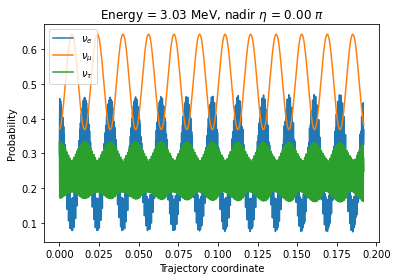

In [28]:
probs = np.square(np.abs(sol))

plt.xlabel("Trajectory coordinate")
plt.ylabel("Probability")
plt.title("Energy = %.2f MeV, nadir $\eta$ = %.2f $\pi$" % (E, eta/pi))
plt.plot(x, probs, label=["$\\nu_e$", "$\\nu_\mu$", "$\\nu_\\tau$"])
plt.legend()

plt.show()

#### Full numerical solution

In [29]:
def model(t, y):
    nue, numu, nutau = y
    dnudt = - 1j * np.dot(Hk + np.diag([MatterPotential(EarthDensity(t)),0,0]), [nue, numu, nutau])
    return dnudt

nu0 = (pmns.transpose()[1, :]).conjugate()

nu = complex_ode(model)

nu.set_integrator("Isoda")
nu.set_initial_value(nu0, 0)


x = np.linspace(x1, x2,10**3)
sol = [nu.integrate(xi) for xi in x[1::]]
sol.insert(0, np.array(nu0)[0])

One_num = sol[-1]
print(x[-1], One_num, nu.successful() )
One_num = np.array([One_num])

/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:389: UserWarning: No integrator name match with 'Isoda' or is not available.
  warnings.warn('No integrator name match with %r or is not '


0.192 [0.10193793-0.59795012j 0.13170883-0.60397542j 0.47542502+0.15084011j] True


#### Analytic solution at 1st order

In [30]:
One_an = np.dot(Upert(0, DeltamSq21, DeltamSq31, E, th12, th13, x2, x1, a, b, c), nu0.transpose()).transpose()
One_an = np.array(One_an)
One_an

array([[0.10210135-0.59784204j, 0.13170984-0.60397541j,
        0.47650543+0.15155572j]])

#### Check differences between numerical, 0th and 1st analytic solutions

In [31]:
err = [np.linalg.norm(Zero_num - Zero_an), 
 np.linalg.norm(One_num - Zero_an),
 np.linalg.norm(One_num - One_an)]

print(err, err[2]<err[1])

[0.0013776030272087492, 0.001363803716565622, 0.00131064116751058] True


In [32]:
err = [angle(Zero_num , Zero_an)[0]/pi, 
 angle(One_num , Zero_an)[0]/pi,
 angle(One_num , One_an)[0]/pi]

print(err, err[2]<err[1])

[0.00039591368909662564, 0.0003937977776197672, 0.00037503930730861944] True


##### Plot the numerical solution

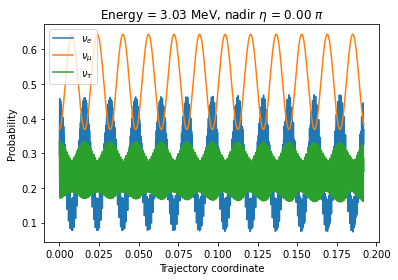

In [33]:
probs = np.square(np.abs(sol))

plt.xlabel("Trajectory coordinate")
plt.ylabel("Probability")
plt.title("Energy = %.2f MeV, nadir $\eta$ = %.2f $\pi$" % (E, eta/pi))
plt.plot(x, probs, label=["$\\nu_e$", "$\\nu_\mu$", "$\\nu_\\tau$"])
plt.legend()

plt.show()

# Path crossing multiple shells

In [34]:
def FullEvolutor (m1Sq, m2Sq, m3Sq, E, th12, th13, th23, d, eta, H):
    """FullEvolutor(m1Sq, m2Sq, m3Sq, E, th12, th13, eta, H) computes the full evolutor for an ultrarelativistic
    neutrino crossing the Earth:
    - miSq are the squared masses (or mass differences) in units of eV^2;
    - E is the neutrino energy, in units of MeV;
    - thij are the PMNS mixing angles;
    - d is the CP-violating PMNS phase;
    - eta is the nadir angle;
    - H is the underground detector depth, in units of meters."""
    
    # If the detector is on the surface and neutrinos are coming from above the horizon, there is no
    # matter effect
    if H == 0 and (pi/2 <= eta <= pi):
        return np.identity(3)
    
    # Detector depth normalised to Earth radius
    h = H/R_E
    
    # Position of the detector along the trajectory coordinate
    r_d = 1 - h # This is valid for eta = 0
    x_d = sqrt(r_d**2 - sin(eta)**2) # For generic values of eta
    
    # Compute the factorised matrices R_{23} and \Delta 
    # (remember that U_{PMNS} = R_{23} \Delta R_{13} \Delta^* R_{12})
    r23= R23(th23)
    delta = Delta(d)
    
    # If 0 <= eta < pi/2 we compute the evolutor taking care of matter density perturbation around the
    # density mean value at first order
    if 0 <= eta < pi/2:
        # params is a list of lists, each element [[a, b, c], x_i] contains the parameters of the density 
        # profile n_e(x) = a + b x^2 + c x^4 along the crossed shell, with each shell ending at x == x_i
        params = EarthDensity(eta=eta, parameters=True)

        # Compute the evolutors for the path from Earth entry point to trajectory mid-point at x == 0
        evolutors_full_path = [Upert(m1Sq, m2Sq, m3Sq, E, th12, th13, params[i][1], params[i-1][1] if i > 0 else 0, 
                           params[i][0][0], params[i][0][1], params[i][0][2]) for i in reversed(range(len(params)))]

        # Multiply the single evolutors
        evolutor_half_full = multi_dot(evolutors_full_path) if len(evolutors_full_path) > 1 else evolutors_full_path[0]
        
        
        # Compute the evolutors for the path from the trajectory mid-point at x == 0 to the detector point x_d
        # Only the evolutor for the most external shell needs to be computed
        evolutors_to_detectors = evolutors_full_path.copy()
        evolutors_to_detectors[0] = Upert(m1Sq, m2Sq, m3Sq, E, th12, th13, x_d, params[-2][1] if len(params) > 1 else 0, 
                           params[-1][0][0], params[-1][0][1], params[-1][0][2])

        # Multiply the single evolutors
        evolutor_half_detector = multi_dot(evolutors_to_detectors) if len(evolutors_to_detectors) > 1 else evolutors_to_detectors[0]

        # Combine the two half-paths evolutors and include the factorised dependence on th23 and d to
        # obtain the full evolutor
        evolutor = multi_dot([r23, delta.conjugate(), evolutor_half_detector, evolutor_half_full.transpose(), 
                              delta, r23.transpose()])
        return evolutor

    # If pi/2 <= eta <= pi we approximate the density to the constant value taken at r = 1 - h/2
    elif pi/2 <= eta <= pi:
        n_1 = EarthDensity(x = 1 - h / 2)

        # Deltax is the lenght of the crossed path
        Deltax = r_d * cos(eta) + sqrt(1 - r_d**2 * sin(eta)**2)

        # Compute the evolutor for constant density n_1 and traveled distance Deltax,
        # and include the factorised dependence on th23 and d to obtain the full evolutor
        evolutor = multi_dot([r23, delta.conjugate(), 
                              Upert(m1Sq, m2Sq, m3Sq, E, th12, th13, Deltax, 0, n_1, 0, 0), 
                              delta, r23.transpose()])
        return evolutor

    else:
        raise ValueError('eta must be comprised between 0 and pi.')

In [35]:
r23= R23(th23)
delta = Delta(d)

eta = np.random.uniform(0, pi)
E = np.random.uniform(1,20)

Hk = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()])

H = 2e3 # meters
h = H/R_E
r_d = 1 - h
x_d = sqrt(r_d**2 - sin(eta)**2)
Deltax = r_d * cos(eta) + sqrt(1 - r_d**2 * sin(eta)**2)
n_1 = EarthDensity(x=1)

params = EarthDensity(eta=eta, parameters=True)
x1, x2 = (-params[-1][1], x_d) if 0 <= eta < pi/2 else (0, Deltax)

def model(t, y):
    nue, numu, nutau = y
    dnudt = - 1j * np.dot(multi_dot([r23, delta.conjugate(), Hk + np.diag([
        MatterPotential(EarthDensity(t, eta=eta)) if 0 <= eta < pi/2 else n_1
        ,0,0]), delta, r23.transpose()]), [nue, numu, nutau])
    return dnudt

nu0 = (pmns.transpose()[1, :]).conjugate()

nu = complex_ode(model)

nu.set_integrator("Isoda")
nu.set_initial_value(nu0, x1)


x = np.linspace(x1, x2, 10**3)
sol = [nu.integrate(xi) for xi in x[1::]]
sol.insert(0, np.array(nu0)[0])

One_num = sol[-1]
print(x[-1], One_num, nu.successful() )
One_num = np.array([One_num])

0.000322050236632232 [ 0.54475292-0.01309936j  0.60678624-0.03031619j -0.57789607-0.00036684j] True


/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:389: UserWarning: No integrator name match with 'Isoda' or is not available.
  warnings.warn('No integrator name match with %r or is not '


In [36]:
One_an = np.dot(FullEvolutor(0, DeltamSq21, DeltamSq31, E, th12, th13, th23, d, eta, H), nu0.transpose()).transpose()
One_an = np.array(One_an)
One_an

array([[ 0.54474241-0.01352735j,  0.60680066-0.03032564j,
        -0.57788052-0.00037511j]])

In [37]:
np.linalg.norm(One_num - One_an)/np.linalg.norm(One_num + One_an)

0.00021441311275695202

In [38]:
angle(One_an, One_num)[0]/pi

0.0001364996247006632

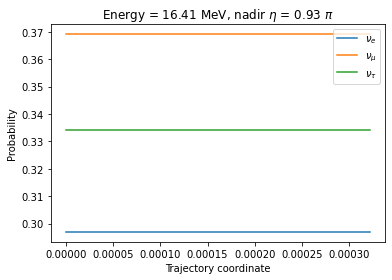

In [39]:
probs = np.square(np.abs(sol))

plt.xlabel("Trajectory coordinate")
plt.ylabel("Probability")
plt.title("Energy = %.2f MeV, nadir $\eta$ = %.2f $\pi$" % (E, eta/pi))
plt.plot(x, probs, label=["$\\nu_e$", "$\\nu_\mu$", "$\\nu_\\tau$"])
plt.legend()

plt.show()

# Sun-Earth survival probability 

In [41]:
th12 = arctan(sqrt(0.469))
th13 = arcsin(sqrt(0.01))
DeltamSq21 = 7.9e-5
DeltamSq31 = 2.46e-3

pmns = multi_dot([r23, delta, r13, delta.conjugate(), r12])

E = np.random.uniform(1, 20)
eta = np.random.uniform(0, pi)

H = 2e3

radius_samples = solar_model.radius
density = solar_model.density
fraction = solar_model['8B fraction']

In [42]:
mass_weights = solar_flux_mass(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction)

mass_to_flavour_probabilitites = np.square(np.abs(np.dot(FullEvolutor(0, DeltamSq21, DeltamSq31, E, th12, th13, th23, d, eta, H), pmns.conjugate())))

flavour_probabilities = np.array(np.dot(mass_to_flavour_probabilitites, mass_weights))

print(E, eta/pi, flavour_probabilities)

14.726722586135418 0.5554338192897118 [[0.31312406 0.34246543 0.34441051]]


# Average over time

In [206]:
from math import sin, cos
from cmath import asin, tan
from cmath import sin as csin
from cmath import cos as ccos
from cmath import sqrt as csqrt
from mpmath import fp, ellipf, sec, csc
from interval import interval


# Sometimes the function cmath.sqrt takes the "wrong" side of the branch cut, if its argument has vanishing 
# imaginary part prepended by a negative sign. To prevent this we define a custom version of the function
def safe_csqrt(z):
    x = z.real
    y = z.imag
    
    if (y == 0.0) or (y == 0):
        return csqrt(x)
    else:
        return csqrt(x + z*1j)
    
    
    
def IndefiniteIntegralDay (T, eta, lam):
    """IndefiniteIntegralDay(T, eta, lam) computes the indefinite integral 
    \int dT [ (1/sqrt(1 - T^2)) * (sec(lam) sin(eta)) / sqrt(1 + sec(lam) (-sec(lam) (cos(eta)^2 + T^2 sin(i)^2) + 
     2 cos(eta) T sin(i) tan(lam))) ].
     This is required in the change of variables from hourly and daily times (\tau_h, \tau_d) to nadir angle eta,
     when computing the eta exposure for a detector within a definite amount of time:
     - T must be interpreted as cos(\tau_d);
     - eta is the nadir angle;
     - lam is the detector latitude.
See Appendix C in hep-ph/9702343 for a more extensive discussion."""
    # Earth rotation axis inclination
    i = 0.4091
    
    return (-2*safe_csqrt(2)*(-1 + T)**2*fp.csc(i)*fp.ellipf(asin(safe_csqrt(-(((1 + T)*(csin(i) - csin(eta + lam)))/
                                                               ((-1 + T)*(csin(i) + csin(eta + lam)))))), 
    ((csin(i) + csin(eta - lam))*(csin(i) + csin(eta + lam)))/((csin(i) - csin(eta - lam))*(csin(i) - csin(eta + lam))))
            *fp.sec(lam)*csin(eta)*safe_csqrt((T*csin(i) + csin(eta - lam))/((-1 + T)*(csin(i) - csin(eta - lam))))*
            safe_csqrt(-(((1 + T)*(csin(i) - csin(eta + lam)))/((-1 + T)*(csin(i) + csin(eta + lam)))))*
            safe_csqrt((T*csin(i) - csin(eta + lam))/((-1 + T)*(csin(i) + csin(eta + lam))))*
            (csin(i) + csin(eta + lam))*safe_csqrt(-1 + ccos(eta)**2*fp.sec(lam)**2 + 
        T**2*fp.sec(lam)**2*csin(i)**2 - 2*T*ccos(eta)*fp.sec(lam)*csin(i)*tan(lam)))/((-1 + fp.csc(i)*csin(eta + lam))*
        safe_csqrt(-2 + (1 + T**2 - T**2*ccos(2*i) + ccos(2*eta))*fp.sec(lam)**2 - 4*T*ccos(eta)*fp.sec(lam)*csin(i)*tan(lam))
        *safe_csqrt((-1 + T**2)*(-1 + ccos(eta)**2*fp.sec(lam)**2 + T**2*fp.sec(lam)**2*csin(i)**2 - 
                            2*T*ccos(eta)*fp.sec(lam)*csin(i)*tan(lam))))


def IntegralAngle (eta, lam, a1=0, a2=pi, eps=1e-5):
    """IntegralAngle(eta, lam, a1, a2, eps) computes the definite integral 
        \int_cos(a2)^cos(a1) dT [ (1/sqrt(1 - T^2)) * (sec(lam) sin(eta)) / 
        sqrt(1 + sec(lam) (-sec(lam) (cos(eta)^2 + T^2 sin(i)^2) + 2 cos(eta) T sin(i) tan(lam))) ].
        This is required when computing the eta exposure for a detector over a finite amount of time.
        The time is expressed in radians of the Earth orbit, with origin at the winter solstice.
        Only half-orbit needs to be considered due to symmetry:
        - eta is the nadir angle;
        - lam is the detector latitude;
        - a1, a2 are the starting the ending angles of the time interval. They must be comprised between 0 and pi;
        - eps is a small quantity needed to regularise the integral, which is locally divergent at extreme values
        of allowed integration range."""
    # Earth rotation axis inclination
    i = 0.4091

    # Check correct range of input times
    if (not 0 <= a1 <= pi) or (not 0 <= a2 <= pi) or (a1 > a2):
        raise ValueError('a1 and a2 must be comprised between 0 and pi, and a2 must be greater than a1')
        
    # Define intervals of valid integration
    int1 = interval[-1 + eps, 1 - eps] # Where the function T = cos(ai) is defined
    int2 = interval[sin(lam - eta)/sin(i) + eps, sin(lam + eta)/sin(i) - eps] # Range where T = cos(ai) can take values for fixed values of lam, eta, i
    int3 = interval[cos(a2), cos(a1)] # Interval of detector time exposure 
    
    # The integration interval is given by the intersection of int1, int2, int3
    int_full = int1 & int2 & int3
    
    # If no intersection then the integral is zero
    if len(int_full) == 0:
        return 0
    
    # If non-empty intersection then define the lower and upper limits of integration
    elif len(int_full) == 1:
        low, up = int_full[0].inf, int_full[0].sup

        # If the integration interval is larger than 2 * eps then compute the definite integral
        # Discard the small imaginary part due to numerics
        if up - low > 2 * eps:
            return ( IndefiniteIntegralDay(up, eta, lam) - IndefiniteIntegralDay(low, eta, lam) ).real
        
        # Otherwise return zero
        else:
            return 0
        
    # The code only works  if the intersection results in a continous interval (i.e. len(int_full) == 1),
    # as is expected. If this is not the case raise an error.
    else:
        raise Exception("Unable to treat disconnected integration intervals")
        
        

def IntegralDay (eta, lam, d1=0, d2=365/2):
    """IntegralDay(eta, lam, d1, d2) computes the non-normalised exposure on the nadir angle eta for an 
    experiment located at latidute lam, taking data from day d1 to day d2. 
    The time origin day = 0 is the northern hemisphere winter solstice midnight.
    The function accepts values of d1, d2 comprised between zero and 365."""
    
    # Check correct range of input times
    if (not 0 <= d1 <= 365) or (not 0 <= d2 <= 365) or (d1 > d2):
        raise ValueError('d1 and d2 must be comprised between 0 and 365, and d2 must be greater than d1')
        
    # Convert days to angles
    [a1, a2] = 2 * pi * np.array([d1, d2]) / 365

    # The calculation is performed separately for first and second half of the year
    int1 = interval[a1, a2] & interval[0, pi] # Between winter and summer solstices
    int2 = interval[a1, a2] & interval[pi, 2 * pi] # Between summer and winter solstices
    
    # Compute the exposure for each half-year
    weight1 = IntegralAngle(eta, lam, int1[0].inf, int1[0].sup) if len(int1) == 1 else 0
    
    # For the second half we use the symmetry of the orbit to recast the trajectory into an equivalent one
    # in the range of days between 0 and 365/2.
    weight2 = IntegralAngle(eta, lam, 2*pi - int2[0].sup, 2*pi - int2[0].inf) if len(int2) == 1 else 0
    
    # Return the sum of the exposures
    return weight1 + weight2

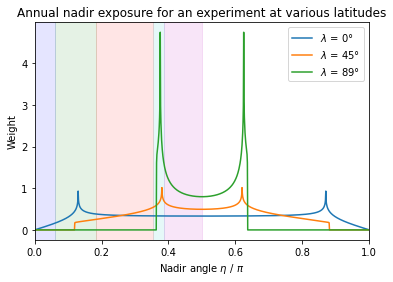

In [207]:
from math import radians, degrees

lat = [0, 45, 89]
shells_eta = np.insert(np.arcsin(np.array([0.192, 0.546, 0.895, 0.937, 1]))/pi, 0, 0)
colors = ['b', 'g', 'r', 'c', 'm']

x = np.linspace(0, pi, 10**3)
dist = [[IntegralDay(eta, radians(lam)) for eta in x] for lam in lat]

plt.xlabel("Nadir angle $\eta$ / $\pi$")
plt.ylabel("Weight")
plt.title("Annual nadir exposure for an experiment at various latitudes")
ax = plt.gca()
ax.set_xlim([0,1])
#plt.vlines(np.arcsin(np.array([0.192, 0.546, 0.895, 0.937, 1]))/pi, ymin=0, ymax=5, linestyles='dashed')
for i in range(len(shells_eta) - 1):
    plt.axvspan(shells_eta[i], shells_eta[i+1], alpha=0.1, color=colors[i])

for lam in range(len(lat)):
    plt.plot(x/pi, np.array(dist[lam])/integrate.trapezoid(x=x,y=dist[lam]), label="$\lambda$ = %.f°" % lat[lam])
plt.legend()

plt.savefig(plots_folder + "eta_weights.pdf")
plt.show()

# Energy spectra

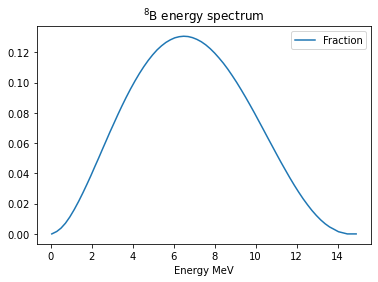

In [107]:
B8_shape = pd.read_csv('./Data/8B_shape.csv', header=None, names=['Energy MeV', 'Fraction'])
B8_shape.Fraction[B8_shape.Fraction < 0] = 0


B8_shape.plot(x='Energy MeV', y='Fraction', title='${}^8$B energy spectrum')
plt.show()

In [98]:
integrate.trapezoid(x=B8_shape['Energy MeV'], y=B8_shape['Fraction'])

0.9959541579254916

In [99]:
from numpy import arctan

th12 = arctan(sqrt(0.469))
th13 = arcsin(sqrt(0.01))
DeltamSq21 = 7.9e-5
DeltamSq31 = 2.46e-3
radius_samples = solar_model.radius
density = solar_model.density
fraction = solar_model['8B fraction']

survival_prob = np.array([PnuenueReaction(th12, th13, DeltamSq21, DeltamSq31, E, radius_samples, density, fraction) for E in B8_shape['Energy MeV']])
distorted_shape = B8_shape.Fraction * survival_prob

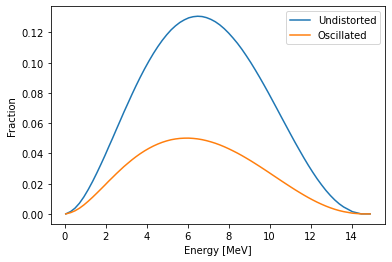

In [104]:
plt.plot(B8_shape['Energy MeV'], B8_shape.Fraction, label='Undistorted')
plt.plot(B8_shape['Energy MeV'], distorted_shape, label='Oscillated')

plt.xlabel('Energy [MeV]')
plt.ylabel('Fraction')

plt.legend()

plt.show()

# Check errors different values of E and eta

In [53]:
np.dot(np.square(np.abs(pmns)), weights).sum()

1.0000000000000004

In [ ]:
r23 = R23(th23)
delta = Delta(d)

eta = 0

x1, x2 = -1, 1

def numerical(E):
    Hk = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()])

    def model(t, y):
        nue, numu, nutau = y
        dnudt = - 1j * np.dot(multi_dot([r23, delta.conjugate(), Hk + np.diag([
            MatterPotential(EarthDensity(t, eta=eta)) if 0 <= eta < pi/2 else n_1
            ,0,0]), delta, r23.transpose()]), [nue, numu, nutau])
        return dnudt

    nu0 = (pmns.transpose()[1, :]).conjugate()

    nu = complex_ode(model)

    nu.set_integrator("Isoda")
    nu.set_initial_value(nu0, x1)


    x = np.linspace(x1, x2, 10**3)
    sol = [nu.integrate(xi) for xi in x[1::]]
    sol.insert(0, np.array(nu0)[0])

    One_num = sol[-1]

    if nu.successful():
        return np.array(One_num)
    else:
        raise Exception("Integration non successful for energy E = %.2f" % E)
        return np.nan
    
def compactU(E):
    return np.array(np.dot(FullEvolutor(0, DeltamSq21, DeltamSq31, E, th12, th13, th23, d, 0, 0), nu0.transpose()).transpose())

In [ ]:
x_log = np.linspace(np.log10(2), 6, 10**3)
x = np.power(10, x_log)

state_an = np.array([compactU(E)[0] for E in x])

In [ ]:
state_num = np.array([numerical(E) for E in x])

In [ ]:
err = angle(state_an, state_num)

In [ ]:
plt.plot(x, err/pi)

plt.yscale("log")
plt.xscale("log")

plt.xlabel("Energy [MeV]")
plt.ylabel("Relative error")

plt.title("Relative error between numerical and analytic computations")
plt.savefig(plots_folder + "error.pdf")

plt.show()

In [54]:
from scipy.special import ellipkinc as F

F(0.1,0.2)

0.10003329662308487

# Not used anymore

In [ ]:
# from math import pi, sqrt, sin, cos

# H = 2e3
# h = H/R_E
# r_d = 1 - h

# eta = np.random.uniform(pi/2, pi)
# E = np.random.uniform(1,20)

# Hk = multi_dot([U, np.diag(k(np.array([0, DeltamSq21, DeltamSq31]), E)), U.transpose()])

# x_d = sqrt(r_d**2 - sin(eta)**2)

# if 0 <= eta < pi/2:
#     params = EarthDensity(eta=eta, parameters=True)

#     evolutors_full_path = [Upert(0, DeltamSq21, DeltamSq31, E, th12, th13, params[i][1], params[i-1][1] if i > 0 else 0, 
#                        params[i][0][0], params[i][0][1], params[i][0][2]) for i in reversed(range(len(params)))]

#     evolutors_to_detectors = evolutors_full_path.copy()
#     evolutors_to_detectors[0] = Upert(0, DeltamSq21, DeltamSq31, E, th12, th13, x_d, params[-2][1] if len(params) > 1 else 0, 
#                        params[-1][0][0], params[-1][0][1], params[-1][0][2])

#     evolutor_half_full = multi_dot(evolutors_full_path) if len(evolutors_full_path) > 1 else evolutors_full_path[0]
#     evolutor_half_detector = multi_dot(evolutors_to_detectors) if len(evolutors_to_detectors) > 1 else evolutors_to_detectors[0]

#     evolutor = np.dot(evolutor_half_detector, evolutor_half_full.transpose())
    
# elif pi/2 <= eta <= pi:
#     n_1 = EarthDensity(x=1)

#     Deltax = r_d * cos(eta) + sqrt(1 - r_d**2 * sin(eta)**2)
    
#     evolutor = Upert(0, DeltamSq21, DeltamSq31, E, th12, th13, Deltax, 0, n_1, 0, 0)
    
# else:
#     raise ValueError('eta must be comprised between 0 and pi.')

In [ ]:
# # Works for eta=0, check for different values

# DeltamSq21 = 7.42e-5
# DeltamSq31 = 2.514e-3
# E = 10
# [th12, th13, th23, d] = [0.583638, 0.149575, 0.855211, 3.40339]
# eta = 0

# from math import sin, cos
# from cmath import exp
# from scipy.linalg import expm
# from numpy.linalg import multi_dot

# R_E = 6.371e6 # meters

# def R23(th):
#     return np.matrix([
#         [1, 0, 0],
#         [0, cos(th), sin(th)],
#         [0, -sin(th), cos(th)]
#     ])

# def R13(th):
#     return np.matrix([
#         [cos(th), 0, sin(th)],
#         [0, 1, 0],
#         [-sin(th), 0, cos(th)]
#     ])

# def R12(th):
#     return np.matrix([
#         [cos(th), sin(th), 0],
#         [-sin(th), cos(th), 0],
#         [0, 0, 1]
#     ])

# def Delta(d):
#     return np.matrix([
#         [1, 0, 0],
#         [0, 1, 0],
#         [0, 0, exp(1j*d)]
#     ])


# [k1, k2, k3] = 2.533 * np.array([0, DeltamSq21, DeltamSq31]) / E

# r13 = R13(th13)
# r12 = R12(th12)
# r23 = R23(th23)
# delta = Delta(d)

# pmns = multi_dot([r23, delta, r13, delta.conjugate(), r12])

# k = np.matrix(np.diag([k1, k2, k3]))

# H0 = r13 * r12 * k * r12.transpose() * r13.transpose()

# H2_12 = (k2 - k1) * cos(th12) * cos(th13) * sin(th12)
# H2_13 = sin(th13) * cos(th13) * ((k2 - k1) * (2 * cos(th12)**2 - 1) + 2 * k3 - k1 - k2) / 2
# H2 = np.array([
#     [0, H2_12, H2_13],
#     [-H2_12, 0, 0],
#     [-H2_13, 0, 0]
# ])

# ME_density = EarthDensity(eta=eta, integrated=True)

# # Need to understand if R_E or R_E^2 in ME2!
# ME1 = [- 1j * R_E * (H0 * ME_density[0][shell] + np.diag([3.868e-7 * (ME_density[1][shell]), 0, 0]) ) for shell in range(len(ME_density[0]))]
# ME2 = [- np.matrix(R_E**2 * H2 * 3.868e-7 * (ME_density[2][shell]) / 2) for shell in range(len(ME_density[0]))]

# ME12 = [expm(ME1[i] + ME2[i]) for i in reversed(range(len(ME1)))]

# evolutor_half = multi_dot(ME12) if len(ME12) > 1 else ME12[0]

# evolutor = multi_dot([r23, delta.conjugate(), evolutor_half, evolutor_half.transpose(), delta, r23.transpose()])

# probabilities = np.square(np.abs(evolutor * pmns[:,1].conjugate()))

# probabilities